## Connectivity

### Imports

In [90]:
import pandas as pd
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
# Matplotlib 3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
from typing import Literal
import matplotlib.pyplot as plt

from typing import Literal
import matplotlib.pyplot as plt

from convergence.plotting import get_hcp_labels
import mne

import mne.datasets
from nilearn.plotting import plot_connectome

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

### Data

In [91]:
data_folder = Path("./data")
filename_separated = data_folder / "cross_subject_pairwise_similarities_0_separated_unbiased_cka.parquet"
filename_joined = data_folder / "cross_subject_pairwise_similarities_0_joined_unbiased_cka.parquet"
filename_hcp = data_folder / "hcp3.csv"
filename_model_joined = data_folder / "subject_model_similarities_cka_joined.parquet"
filename_model_separated = data_folder / "subject_model_similarities_cka.parquet"

output_folder = Path("figures_connectivity")
output_folder.mkdir(exist_ok=True)

### Functions

In [92]:
def load_peak_layers(filename, group_subjects=False, modality="vision", aggfunc="mean"):
    df = pd.read_parquet(filename)
    df = df.query(f"modality=='{modality}' and not excluded and score < 1 and score > -0.05").copy()
    # Add max layer per model
    df["n_layers"] = df.groupby("model_name", observed=True).layer.transform("max")
    df = df.sort_values("score", ascending=False).drop_duplicates(subset=["subject", "roi", "session", "model_name"], keep="first")
    df["depth"] = df.layer / df.n_layers
    df = df.groupby(["roi", "subject", "model_name"], observed=True).aggregate({"score": "mean", "depth": aggfunc}).reset_index()
    df = df.groupby(["roi", "subject"], observed=True).aggregate({"score": "mean", "depth": aggfunc}).reset_index()
    if group_subjects:
        df = df.groupby(["roi"], observed=True).aggregate({"score": "mean", "depth": aggfunc}).reset_index()
    hcp = pd.read_csv(filename_hcp)
    hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
    df = df.merge(hcp, on="roi")
    return df



def plot_connection(
    start,
    end,
    ax,
    color="black",
    alpha=1,
    linewidth=1,
    zorder=0,
    direction: Literal["->", "<-", "-"] = "-",
    arrow_size=10
):
    if direction == "-":
        ax.plot(
            [start[0], end[0]],
            [start[1], end[1]],
            color=color,
            alpha=alpha,
            linewidth=linewidth,
            zorder=zorder,
        )
    else:
        # Reverse if direction is "<-"
        if direction == "<-":
            start, end = end, start
            direction = "->"

        ax.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(
                arrowstyle=direction,
                color=color,
                alpha=alpha,
                linewidth=linewidth,
                mutation_scale=arrow_size,
                zorder=1000,
            ),
            zorder=zorder,
        )

def plot_cbar(figsize=None, cmap="viridis", vmin=0, vmax=0.2, horizontal=False, title="", percent=True, locator=0.05, rotation=-90, labelpad=20, fontsize=12, loc=None,**kwargs):

    if figsize is None:
        figsize = (6, 0.4) if horizontal else (0.4, 6)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a colormap normalization
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Create a scalar mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for ScalarMappable

    # Add the colorbar
    orientation = 'horizontal' if horizontal else 'vertical'
    cbar_instance = fig.colorbar(sm, cax=ax, orientation=orientation, **kwargs)
    cbar_instance.set_label(title, rotation=rotation, labelpad=labelpad, fontsize=fontsize, loc=loc)
    
    if percent:
        ticker = mticker.PercentFormatter(xmax=1, decimals=0)
        cbar_instance.formatter = ticker
    if locator:
        cbar_instance.locator = mticker.MultipleLocator(base=locator)

    
    return fig, ax

### Subfigure: Connectivity matrix

Index(['DVT', 'FFC', 'FST', 'IP0', 'IPS1', 'LO2', 'LO3', 'MST', 'MT', 'PGp',
       'PH', 'PHA1', 'PHA2', 'PHA3', 'PHT', 'PIT', 'POS1', 'PreS', 'ProS',
       'STV', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'V1', 'V2', 'V3', 'V3A', 'V3B',
       'V3CD', 'V4', 'V4t', 'V8', 'VMV1', 'VMV2', 'VMV3', 'VVC'],
      dtype='object', name='name_y')


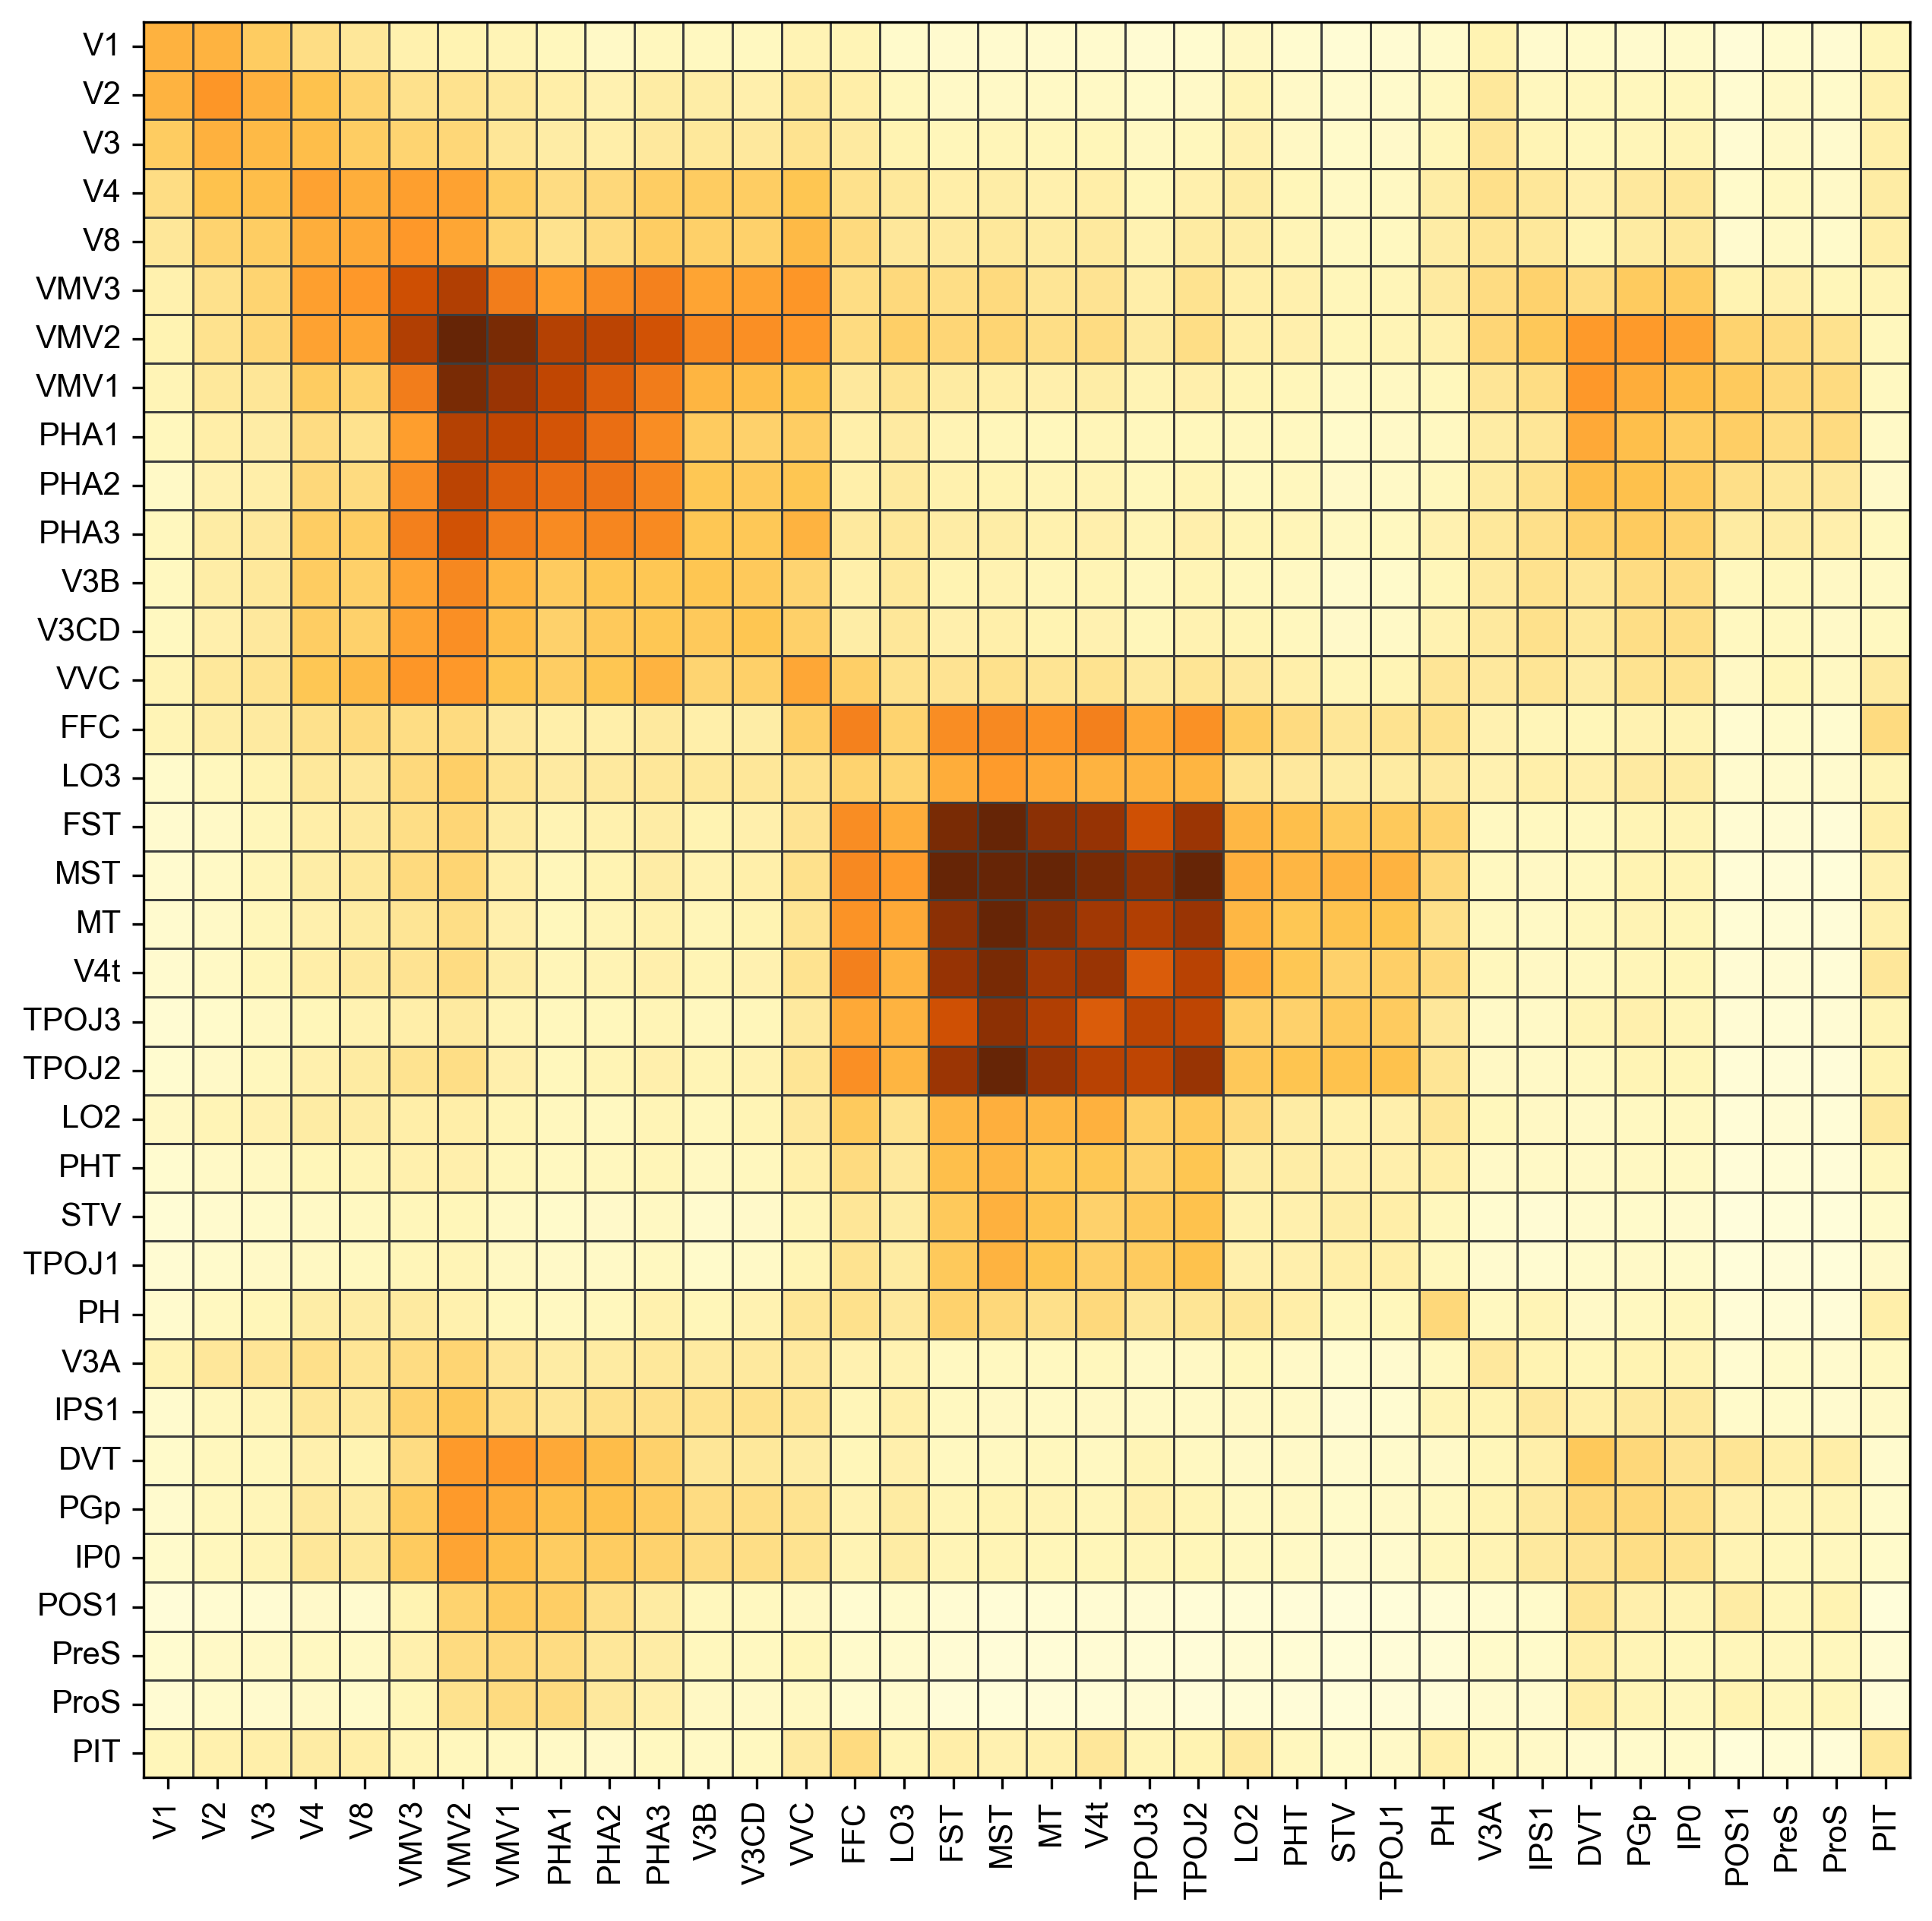

In [6]:

order = [
    'V1', 'V2', 'V3', 'V4', 
    'V8', 'VMV3', 'VMV2', 'VMV1', 
    'PHA1', 'PHA2', 'PHA3',
    
    'V3B', 'V3CD', 'VVC',
    'FFC','LO3',
    'FST', 'MST', 'MT', 'V4t', 
    'TPOJ3','TPOJ2', 
      'LO2', 
        'PHT', 
       'STV', 'TPOJ1',   
       'PH',
        
         'V3A', 'IPS1','DVT',  'PGp',
          'IP0',
        'POS1', 'PreS', 'ProS',
        
        'PIT',

]

df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.pivot(index="name_x", columns="name_y", values="score")



df = df[df.max(axis=1) > 0.05]
df = df[df.index]
print(df.columns)
df = df.loc[order, order]


fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
#sns.heatmap(data=df, ax=ax, cbar_kws={"shrink": 0.5}, cmap="hot", vmin=0, vmax=0.2)
cmap = "YlOrBr"
ax.pcolormesh(df.values[::-1, :],  cmap=cmap, vmin=0, vmax=0.18, edgecolors=(0.24, 0.24, 0.24), linewidth=0.3)
ax.set_aspect("auto")
ax.set_xlabel("")
ax.set_ylabel("")

# Add a contour line
# Set all ticks
ax.set_xticks(0.5+np.arange(len(df.columns)))
ax.set_yticks(0.5+np.arange(len(df)))
ax.set_xticklabels(df.columns, rotation=90, ha="center")
ax.set_yticklabels(df.index[::-1], rotation=0, va="center")


# Rotate yticklabels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0);

folder = output_folder / "heatmap_connectivity"
folder.mkdir(exist_ok=True)

plt.savefig(folder / "heatmap_connectivity_selected_huge.svg", bbox_inches="tight", transparent=True)
plt.savefig(folder / "heatmap_connectivity_selected_huge.pdf", bbox_inches="tight", transparent=True)

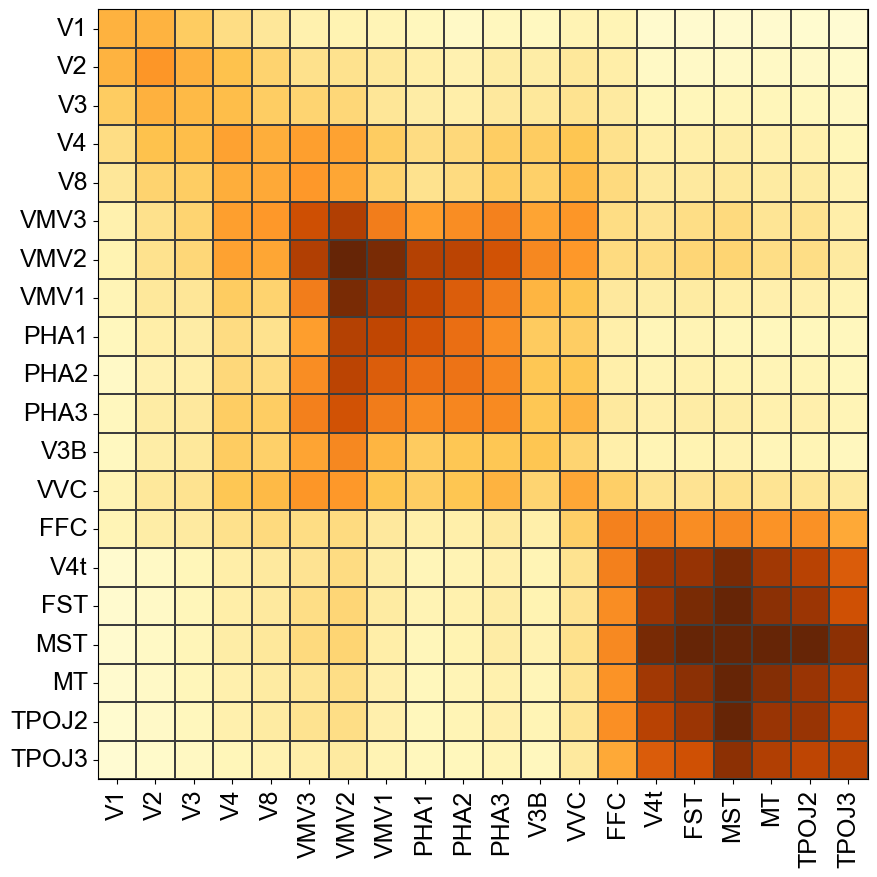

In [89]:
order = ['V1', 'V2', 'V3', 'V4', # Early visual
         'V8',
          
           'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
         
         'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         'V3B', 
         'VVC', 
         
         'FFC', # Ventral
            # TPO
         'V4t','FST', 'MST', 'MT', 'TPOJ2', 'TPOJ3', # 'LO3', 'LO2',#'LO1',
         #'STV', 'TPOJ1',
         #'PH', 
         #'V3CD',
             # MT+ visual areas
          #'IPS1', 'V3A', # 'V6A', 'V7' , # Dorsal visual
         ] 


df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.pivot(index="name_x", columns="name_y", values="score")
df = df.loc[order, order]


fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(data=df, ax=ax, cbar_kws={"shrink": 0.5}, cmap="hot", vmin=0, vmax=0.2)
ax.pcolormesh(df.values[::-1, :],  cmap="YlOrBr", vmin=0, vmax=0.18, edgecolors=(0.24, 0.24, 0.24), linewidth=0.3)
ax.set_aspect("equal")
ax.set_xlabel("")
ax.set_ylabel("")

# Add a contour line
# Set all ticks
ax.set_xticks(0.5+np.arange(len(df)))
ax.set_yticks(0.5+np.arange(len(df)))
fontsize = 18
ax.set_xticklabels(df.columns, rotation=90, ha="center", fontsize=fontsize)
ax.set_yticklabels(df.index[::-1], rotation=0, va="center", fontsize=fontsize)


folder = output_folder / "heatmap_connectivity"
folder.mkdir(exist_ok=True)

plt.savefig(folder / "heatmap_connectivity_selected_2.svg", bbox_inches="tight", transparent=True)
plt.savefig(folder / "heatmap_connectivity_selected_2.pdf", bbox_inches="tight", transparent=True)

### Graph 2D

In [8]:
df_peaks = load_peak_layers(filename_model_joined, group_subjects=True)
df_peaks_name = df_peaks.set_index("name")
df_peaks

,roi,score,depth,name,area,area_id,area_color,roi_order,mne_name
0,1,0.096494,0.222972,V1,Primary Visual,0,#1f77b4,0,L_V1_ROI-lh
1,2,0.130800,0.804544,MST,MT+ Visual Areas,6,#2ca02c,24,L_MST_ROI-lh
2,3,0.017969,0.647724,V6,Dorsal Visual,5,#ff9896,7,L_V6_ROI-lh
3,4,0.089754,0.305634,V2,Early Visual (V2-4),1,#aec7e8,1,L_V2_ROI-lh
4,5,0.071921,0.407533,V3,Early Visual (V2-4),1,#aec7e8,2,L_V3_ROI-lh
...,...,...,...,...,...,...,...,...,...
175,176,0.014023,0.676826,STSva,Auditory Association,13,#f7b6d2,64,L_STSva_ROI-lh
176,177,0.008105,0.504024,TE1m,Lateral Temporal,4,#d62728,89,L_TE1m_ROI-lh
177,178,0.004391,0.472403,PI,Insula & Frontal Operculum,14,#7f7f7f,75,L_PI_ROI-lh
178,179,0.005300,0.584981,a32pr,Anterior Cingulate & mPFC,18,#17becf,141,L_a32pr_ROI-lh


In [60]:
#df_peaks_participant = load_peak_layers(filename_model_joined, group_subjects=False)
df_edges_depth = df_edges.merge(df_peaks_participant[["roi", "depth", "subject"]], left_on="roi_x", right_on="roi").rename(columns={"depth": "depth_x"}).drop(columns=["roi", "weight"])
df_edges_depth = df_edges_depth.merge(df_peaks_participant[["roi", "depth", "subject"]], left_on=["roi_y", "subject"], right_on=["roi", "subject"]).rename(columns={"depth": "depth_y"}).drop(columns="roi")


# For each pair of rois, do a paired t-test of wether the depth is different
from scipy.stats import ttest_rel
df_edges_depth_grouped = df_edges_depth.groupby(["roi_x", "roi_y", "name_x", "name_y"])[["depth_x", "depth_y"]].apply(lambda x: ttest_rel(x.depth_x, x.depth_y))
df_edges_depth_grouped = df_edges_depth_grouped.reset_index()
df_edges_depth_grouped["ttest"] = df_edges_depth_grouped[0].str[0]
df_edges_depth_grouped["p-value"] = df_edges_depth_grouped[0].str[1]
df_edges_depth_grouped = df_edges_depth_grouped.drop(columns=0)
df_edges_depth_grouped["significant"] = df_edges_depth_grouped["p-value"] < 0.05
df_edges_depth_grouped.query("significant").sort_values("roi_x")

p_values = df_edges_depth_grouped["p-value"].values
# Use fdr correction
from statsmodels.stats.multitest import multipletests
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")
df_edges_depth_grouped["p-value_corrected"] = p_values_corrected
df_edges_depth_grouped["significant-corrected"] = df_edges_depth_grouped["p-value_corrected"] < 0.05
df_edges_depth_grouped


,roi_x,roi_y,name_x,name_y,ttest,p-value,significant,p-value_corrected,significant-corrected
0,1,4,V1,V2,-5.221125,0.001224,True,0.005892,True
1,1,5,V1,V3,-6.008035,0.000538,True,0.003186,True
2,2,18,MST,FFC,3.824599,0.006503,True,0.016153,True
3,2,23,MST,MT,1.992089,0.086624,False,0.125755,False
4,2,140,MST,TPOJ2,-0.414762,0.690732,False,0.728581,False
...,...,...,...,...,...,...,...,...,...
149,163,127,VVC,PHA3,0.727297,0.490647,False,0.555586,False
150,163,153,VVC,VMV1,2.724095,0.029590,True,0.051783,False
151,163,154,VVC,VMV3,-0.509137,0.626308,False,0.678698,False
152,163,155,VVC,PHA2,1.703283,0.132296,False,0.185214,False


In [193]:
df_edges_depth_areas = df_edges_depth.copy()
df_edges_depth_areas = df_edges_depth_areas.merge(hcp[["roi", "area", "area_id"]], left_on="roi_x", right_on="roi").rename(columns={"area": "area_x", "area_id": "area_id_x"}).drop(columns="roi")
df_edges_depth_areas = df_edges_depth_areas.merge(hcp[["roi", "area", "area_id"]], left_on="roi_y", right_on="roi").rename(columns={"area": "area_y", "area_id": "area_id_y"}).drop(columns="roi")
df_edges_depth_areas = df_edges_depth_areas.groupby(["subject", "area_x", "area_y", "area_id_x", "area_id_y"]).aggregate({"depth_x": "mean", "depth_y": "mean", "score": "mean"}).reset_index()
df_edges_depth_areas = df_edges_depth_areas.query("area_id_x < area_id_y")


#df_edges_depth_areas
# Compute the ttest on depth for each pair of areas

df_edges_depth_areas_grouped = df_edges_depth_areas.groupby(["area_x", "area_y"])[["depth_x", "depth_y"]].apply(lambda x: ttest_rel(x.depth_x, x.depth_y))


df_edges_depth_areas_grouped = df_edges_depth_areas_grouped.reset_index()

df_edges_depth_areas_grouped["score"] = df_edges_depth_areas.groupby(["area_x", "area_y"]).score.mean().values
df_edges_depth_areas_grouped["ttest"] = df_edges_depth_areas_grouped[0].str[0]
df_edges_depth_areas_grouped["p-value"] = df_edges_depth_areas_grouped[0].str[1]
df_edges_depth_areas_grouped = df_edges_depth_areas_grouped.drop(columns=0)
# # Correct for multiple comparisons
p_values = df_edges_depth_areas_grouped["p-value"].values
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")
df_edges_depth_areas_grouped["p-value_corrected"] = p_values_corrected
df_edges_depth_areas_grouped["significant-corrected"] = df_edges_depth_areas_grouped["p-value_corrected"] < 0.05
# Make bins of *, **, *** for the p-values
df_edges_depth_areas_grouped["significant-corrected-level"] = df_edges_depth_areas_grouped["p-value_corrected"].apply(lambda x: "***" if x < 0.001 else ("**" if x < 0.01 else ("*" if x < 0.05 else "")))
df_edges_depth_areas_grouped



,area_x,area_y,score,ttest,p-value,p-value_corrected,significant-corrected,significant-corrected-level
0,Early Visual (V2-4),Dorsal Visual,0.061498,-4.883244,0.001787,0.003904,True,**
1,Early Visual (V2-4),Medial Temporal,0.056869,-3.811222,0.006617,0.011029,True,*
2,Early Visual (V2-4),Ventral Visual,0.067402,-11.101514,0.000011,0.000107,True,***
3,MT+ Visual Areas,TPO,0.150707,-1.648969,0.143143,0.159047,False,
4,Medial Temporal,Dorsal Visual,0.064587,-3.102950,0.017251,0.024644,True,*
5,Primary Visual,Early Visual (V2-4),0.069129,-7.140010,0.000187,0.000935,True,***
6,Ventral Visual,Dorsal Visual,0.074637,-2.805181,0.026328,0.032909,True,*
7,Ventral Visual,MT+ Visual Areas,0.079160,-5.495147,0.000911,0.003037,True,**
8,Ventral Visual,Medial Temporal,0.103118,1.115981,0.301269,0.301269,False,
9,Ventral Visual,TPO,0.088317,-4.806232,0.001952,0.003904,True,**


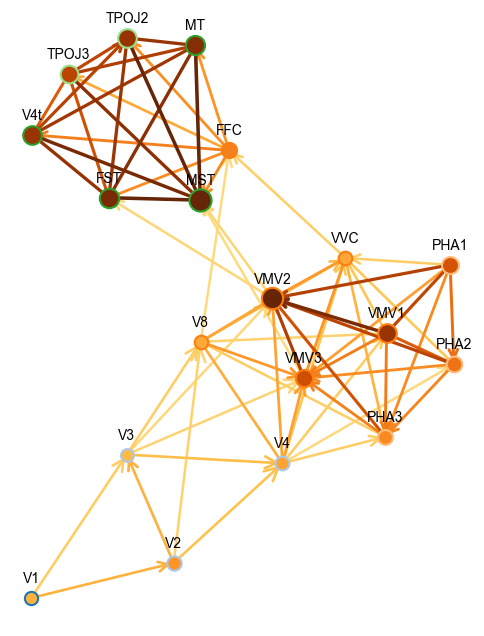

In [164]:
df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j and shift==0")
df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})


threshold_edges = 0.051
top_nodes = 20

df_edges = df.query("name_x != name_y and score > @threshold_edges").copy()

df_self = df.query("name_x==name_y")
nodes = df_self.sort_values("score", ascending=False).head(top_nodes).name_x.tolist()
df_edges = df_edges[df_edges.name_x.isin(nodes) & df_edges.name_y.isin(nodes)]

#counts = df_edges.roi_x.value_counts()
#counts[counts > 1]
#df_edges = df_edges[df_edges.roi_x.isin(counts[counts > 1].index) & df_edges.roi_y.isin(counts[counts > 1].index)]

df_nodes = df.query("name_x == name_y")
df_nodes = df_nodes[df_nodes.roi_x.isin(df_edges.roi_x)]
df_edges["weight"] = 100* (1 - df_edges["score"])
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

vmin, vmax = 0, 0.18
cmap = plt.get_cmap("YlOrBr")

G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)
pos = nx.kamada_kawai_layout(G, dim=2, weight="weight", center=(0, 0))
#if 'VVC' in pos:
#    pos["VVC"] += (-0.1, 0.)
#pos["VMV2"] += (0.1, 0.1)
#pos = nx.spring_layout(G, weight="weight", center=(0, 0), scale=2)
if top_nodes <=20:
    pos["MST"] += (0.1, -0.1)
    # pos["VMV3"] += (0, -0.1)
    pos["V8"] += (0, 0.1)
    pos["TPOJ3"], pos["V4t"] = pos["V4t"], pos["TPOJ3"]
    # pos["VMV1"], pos["PHA3"] = pos["PHA3"], pos["VMV1"]
    pos["PHA3"] += (0.1, -0.1)
    pos["VMV3"] += (0.1, -0.1)


node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


# Draw the graph
fig, ax = plt.subplots(figsize=(6, 8))
ax.axis("off")

#cmap = plt.get_cmap("magma")
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# MT cluster
mt_cluster = ["MST", "MT", "V4t", "FST", "TPOJ2", "TPOJ3"]
ventral_cluster = ["VMV3", "VMV2", "VMV1", "PHA1", "PHA2", "PHA3"]
vc = ["V1", "V2", "V3", "V4"]
exclude = ["V3B"]
markers = {}
for c in mt_cluster:
    markers[c] = "s"
for c in ventral_cluster: # Rombo
    markers[c] = "D"
for c in vc: # Rombo
    markers[c] = "^"

node_positions = {node: pos[node] for node in G.nodes()}
for node, (x, y) in node_positions.items():
    if node not in node_score or node in exclude:
        continue
    score = node_score[node]["score"]
    norm_score = norm(score)


    color = cmap(norm_score)
    s = 5 + 200 * norm_score
    area_color = colors[areas[node]]

    #marker = markers.get(node, "o")
    marker = "o"
    ax.scatter(
        x,
        y,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
        marker=marker,
    )

    # color = f"C{communities[node]}"#communities_colors[communities[node]]
    
    ax.text(x, y + 0.05, node, fontsize=10, ha="center", zorder=1000)

edge_positions = [
    (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
]


depths = []
for name_x, name_y, start, end, score in edge_positions:
    if name_x not in node_score or name_y not in node_score or name_x in exclude or name_y in exclude:
        continue
    xs, ys = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1.5 + 1 * normalize_edge_weight
    color = cmap(normalize_edge_weight)

    depth_x = float(df_peaks_name.loc[name_x].depth)
    depth_y = float(df_peaks_name.loc[name_y].depth)

    diff = abs(depth_x - depth_y)
    #color = cmap(diff*2)
    diff_stat = df_edges_depth_grouped.query("name_x == @name_x and name_y == @name_y")["significant-corrected"]
    if diff_stat.empty:
        direction = "-"
    else:
        diff_stat = diff_stat.values[0]
    if not diff_stat:
        direction = "-"
    else:
        if depth_x < depth_y:
            direction = "->"
        elif depth_x > depth_y:
            direction = "<-"
        else:
            direction = "-"
    
    plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=15+diff*30)


folder = output_folder / "connectivity_graph"
folder.mkdir(exist_ok=True)
fig.savefig(folder / f"connectivity_graph_cka_cross_subject_top_{top_nodes}_no_v3b.svg", dpi=300, bbox_inches="tight", transparent=True)

# order = [
#     'V1', 'V2', 'V3', 'V4', 
#     'V8', 'VMV3', 'VMV2', 'VMV1', 
#     'PHA1', 'PHA2', 'PHA3',
#     'IP0', 'IPS1',
#     'V3A', 'V3B', 'V3CD', 'VVC', 'DVT',  'PGp',

#     'FST', 'MST', 'MT', 'V4t', 
#     'TPOJ3','TPOJ2', 
#     'FFC',  'LO2', 'LO3',
#        'PH',  'PHT', 
#        'STV', 'TPOJ1',   
       
#        'PIT', 
#        'POS1', 'PreS', 'ProS',
# ]

,roi_x,roi_y,name_x,name_y,ttest,p-value,significant,p-value_corrected,significant-corrected
0,1,4,V1,V2,-5.221125,0.001224,True,0.005892,True
1,1,5,V1,V3,-6.008035,0.000538,True,0.003186,True
2,2,18,MST,FFC,3.824599,0.006503,True,0.016153,True
3,2,23,MST,MT,1.992089,0.086624,False,0.125755,False
4,2,140,MST,TPOJ2,-0.414762,0.690732,False,0.728581,False
...,...,...,...,...,...,...,...,...,...
149,163,127,VVC,PHA3,0.727297,0.490647,False,0.555586,False
150,163,153,VVC,VMV1,2.724095,0.029590,True,0.051783,False
151,163,154,VVC,VMV3,-0.509137,0.626308,False,0.678698,False
152,163,155,VVC,PHA2,1.703283,0.132296,False,0.185214,False


In [12]:
df_edges.to_parquet("graph_top_edges_20_rois.parquet")

In [1]:
order = [
    'V1', 'V2', 'V3', 'V4', 
    'V8', 'VMV3', 'VMV2', 'VMV1', 
    #'V3A', 
    'PHA1', 'PHA2', 'PHA3',
    'IP0',# 'IPS1',
    'V3B', 'V3CD', 'VVC', 'DVT',  'PGp',

    'FST', 'MST', 'MT', 'V4t', 
    'TPOJ3','TPOJ2', 
    'FFC',  
    #'LO2',
      'LO3',
       #'PH',  
       'PHT', 
       'STV', 'TPOJ1',   
       
       #'PIT', 
       #'POS1', 'PreS', 'ProS', 
]

df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j and shift==0")
df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})


threshold_edges = 0.051
top_nodes = 20

df_edges = df.query("name_x != name_y and score > @threshold_edges").copy()

df_self = df.query("name_x==name_y")
nodes = order # df_self.sort_values("score", ascending=False).head(top_nodes).name_x.tolist()

df_edges = df_edges[df_edges.name_x.isin(nodes) & df_edges.name_y.isin(nodes)]

#counts = df_edges.roi_x.value_counts()
#counts[counts > 1]
#df_edges = df_edges[df_edges.roi_x.isin(counts[counts > 1].index) & df_edges.roi_y.isin(counts[counts > 1].index)]

df_nodes = df.query("name_x == name_y")
df_nodes = df_nodes[df_nodes.roi_x.isin(df_edges.roi_x)]
df_edges["weight"] = 100* (1 - df_edges["score"])**3
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

vmin, vmax = 0, 0.20

G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)
pos = nx.kamada_kawai_layout(G, dim=2, weight="weight", center=(0, 0))
#if 'VVC' in pos:
#    pos["VVC"] += (-0.1, 0.)
#pos["VMV2"] += (0.1, 0.1)
#pos = nx.spring_layout(G, weight="weight", center=(0, 0), scale=2)
# if top_nodes == 20:
#     pos["MST"] += (0.1, -0.1)
#     pos["VMV3"] += (0, -0.1)
#     pos["V8"] += (0, 0.1)
#     pos["TPOJ2"], pos["V4t"] = pos["V4t"], pos["TPOJ2"]
#     pos["VMV1"], pos["PHA3"] = pos["PHA3"], pos["VMV1"]


node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")

# Draw the graph
fig, ax = plt.subplots(figsize=(6, 8))
ax.axis("off")
cmap = plt.get_cmap("YlOrBr")
norm = plt.Normalize(vmin=vmin, vmax=vmax)


node_positions = {node: pos[node] for node in G.nodes()}
for node, (x, y) in node_positions.items():
    if node not in node_score:
        continue
    score = node_score[node]["score"]
    norm_score = norm(score)


    color = cmap(norm_score)
    s = 1.5 + 200 * norm_score
    area_color = colors[areas[node]]

    ax.scatter(
        x,
        y,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
    )

    # color = f"C{communities[node]}"#communities_colors[communities[node]]
    
    ax.text(x, y + 0.05, node, fontsize=10, ha="center", zorder=1000)

edge_positions = [
    (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
]


depths = []
for name_x, name_y, start, end, score in edge_positions:
    if name_x not in node_score or name_y not in node_score:
        continue
    xs, ys = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1 + 2 * normalize_edge_weight
    color = cmap(normalize_edge_weight)

    depth_x = float(df_peaks_name.loc[name_x].depth)
    depth_y = float(df_peaks_name.loc[name_y].depth)

    diff = abs(depth_x - depth_y)
    #color = cmap(diff*2)

    if diff < 0.0:
        direction = "-"
    elif depth_x < depth_y:
        direction = "->"
    elif depth_x > depth_y:
        direction = "<-"
    else:
        direction = "-"
    
    plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=15+diff*30)



NameError: name 'pd' is not defined

Text(45.722222222222214, 0.5, '')

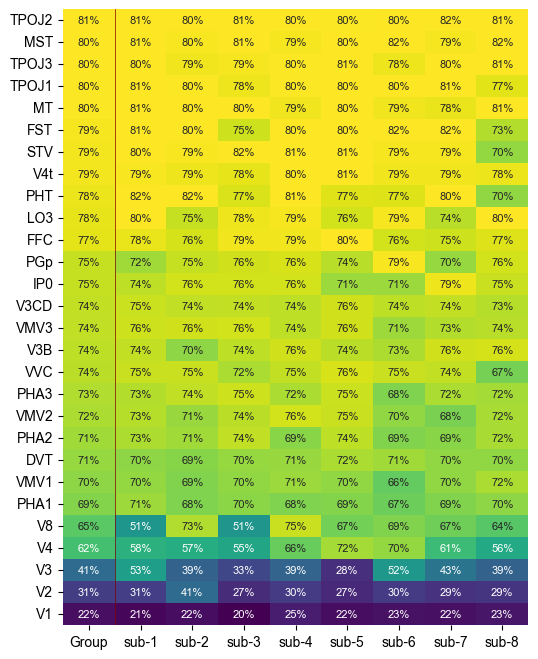

In [158]:
df_peaks2 = load_peak_layers(filename_model_joined, group_subjects=False, modality="vision", aggfunc="mean")
df_peaks_subjects = df_peaks2.query("name in @order")
cmap = "viridis"
group_name = "Group"

# Pivot index name, columns subject, values depth
df_peaks_subjects = df_peaks_subjects.pivot(index="name", columns="subject", values="depth")
df_peaks_subjects.columns = [f"sub-{c}" for c in df_peaks_subjects.columns]
# Add a column with mean depth by all subjects
df_peaks_subjects[group_name] = df_peaks_subjects.mean(axis=1)
# Reorder columns. First group, then subjects
df_peaks_subjects = df_peaks_subjects[[group_name] + [c for c in df_peaks_subjects.columns if c != group_name]]

df_peaks_subjects = df_peaks_subjects.sort_values(group_name, ascending=False)

# Per column, compute the rank
df_peaks_subjects_rank = df_peaks_subjects.rank(axis=0).astype(int)

# Plot a heatmap with the rank columns subjects, index areas
fig, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(data=df_peaks_subjects, ax=ax, cmap=cmap, cbar_kws={"shrink": 0.5}, annot=True, fmt=".0%", vmin=0.2, vmax=0.8, annot_kws={"fontsize": 8}, cbar=False)
# Add a vertical line to separate group from subjects
ax.axvline(1, color="maroon", ls='-', linewidth=0.5)
ax.set_xlabel("")
ax.set_ylabel("")

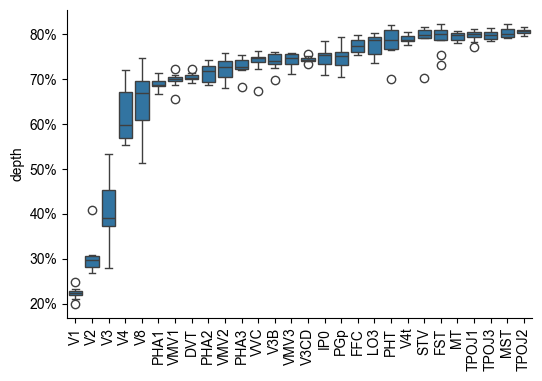

In [ ]:
df_peaks_subjects_flatten = df_peaks_subjects.sort_values("Group").unstack().reset_index()
df_peaks_subjects_flatten.columns = ["subject", "name", "depth"]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_peaks_subjects_flatten.query("subject != 'Group'"), x='name', y='depth', ax=ax)
ax.set_xlabel("")
sns.despine(ax=ax)
plt.xticks(rotation=90)

mtl_cluster = df_peaks_subjects_flatten[df_peaks_subjects_flatten.name.isin(["VMV2", "VMV1", "VMV3", "PHA1", "PHA2", "PHA3"])].query("subject != 'Group'").depth.mean()
mt_cluster  = df_peaks_subjects_flatten[df_peaks_subjects_flatten.name.isin(["MT", "MST", "V4t", "TPOJ2", "TPOJ3", "FST"])].query("subject != 'Group'").depth.mean()
#ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))


# Set a quantile scale







In [103]:
hcp = pd.read_csv(filename_hcp)
hcp.drop_duplicates("area").sort_values("area_id")[["area", "area_color"]]

,area,area_color
0,Primary Visual,#1f77b4
3,Early Visual (V2-4),#aec7e8
6,Ventral Visual,#ff7f0e
117,Medial Temporal,#ffbb78
130,Lateral Temporal,#d62728
2,Dorsal Visual,#ff9896
1,MT+ Visual Areas,#2ca02c
24,TPO,#98df8a
7,Somatomotor,#9467bd
35,Mid Cingulate,#c5b0d5


PosixPath('figures_connectivity/connectivity_graph')

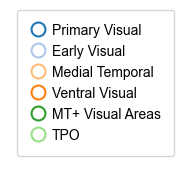

In [111]:
fig2, ax2 = plt.subplots(figsize=(1, 1))
handles = []

colors = {'Primary Visual': '#1f77b4',
 'Early Visual': '#aec7e8',
 #'Dorsal Visual': '#ff9896',
 'Medial Temporal': '#ffbb78',
 'Ventral Visual': '#ff7f0e',
 'MT+ Visual Areas': '#2ca02c',
 'TPO': '#98df8a'}


for area, c in colors.items():

    handles.append(plt.Line2D(
        [0], [0],
        marker='o',
        color='none',            # no connecting line
        markerfacecolor='white', # white center
        markeredgecolor=c,       # colored border
        markeredgewidth=1.5,
        markersize=10,
        linewidth=0,
        label=area,
    ))
    
ax2.axis('off')
# Increase border padding only in top and bottom
ax2.legend(handles=handles, loc="lower left", fontsize=10, title="", title_fontsize=8, borderpad=1, labelspacing=0.5, handletextpad=0.5, handlelength=1, handleheight=1, ncol=1)
fig2.savefig(folder / "legend_areas.svg", dpi=300, bbox_inches="tight", transparent=True)
fig2.savefig(folder / "legend_areas.pdf", dpi=300, bbox_inches="tight", transparent=True)
colors
folder

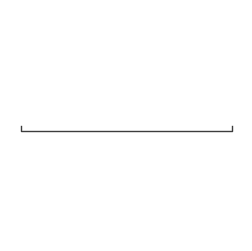

In [130]:
def add_pvalue_bracket(ax, x1, x2, y, height, color=(0.24, 0.24, 0.24), linewidth=1, text=None, y_text=None, **kwargs):
    """
    Draws a bracket (like those used to denote p-values) on a given axis.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis on which to plot the bracket.
    x1, x2 : float
        The x-coordinates between which the bracket is drawn.
    y : float
        The y-coordinate at which the bracket starts.
    height : float
        The vertical distance (height) of the bracket.
    color : str, optional
        The color of the lines.
    linewidth : float, optional
        The width of the lines.
    """
    # Draw the bracket:
    #   Vertical line up from (x1, y) to (x1, y+height)
    #   Horizontal line from (x1, y+height) to (x2, y+height)
    #   Vertical line down from (x2, y+height) to (x2, y)
    ax.plot([x1, x1, x2, x2],
            [y, y + height, y + height, y],
            color=color, linewidth=linewidth)
    if text:
        if not y_text:
            y_text = y + height
        ax.text((x1 + x2) * .5, y_text, text, ha='center', **kwargs)
    


fig, ax = plt.subplots(figsize=(3, 3))
add_pvalue_bracket(ax, 0, 1, 1, -0.05, text="", y_text=1.1-0.3, fontsize=8)
ax.set_ylim(0, 2)
ax.axis('off')
fig.savefig(folder / "line.svg", dpi=300, bbox_inches="tight", transparent=True)

PosixPath('figures_connectivity/heatmap_connectivity')

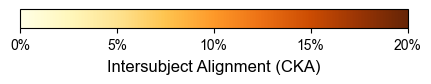

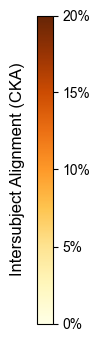

In [78]:
fig, ax = plot_cbar(cmap="YlOrBr", title="Intersubject Alignment (CKA)", vmin=0, vmax=0.20, locator=0.05, horizontal=True, rotation=0, labelpad=5, figsize = (5, 0.25))
fig.savefig(folder / "colorbar_20_YlOrBr.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_20_YlOrBr.pdf", bbox_inches="tight", dpi=300, transparent=True)


fig, ax = plot_cbar(cmap="YlOrBr", title="Intersubject Alignment (CKA)", vmin=0, vmax=0.20, locator=0.05, horizontal=False, rotation=90, labelpad=-58, figsize = (0.2, 4), loc="center")
fig.savefig(folder / "colorbar_20_YlOrBr_vertical.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_20_YlOrBr_vertical.pdf", bbox_inches="tight", dpi=300, transparent=True)
#plt.close()
folder

### Subfigure: Alignment by areas

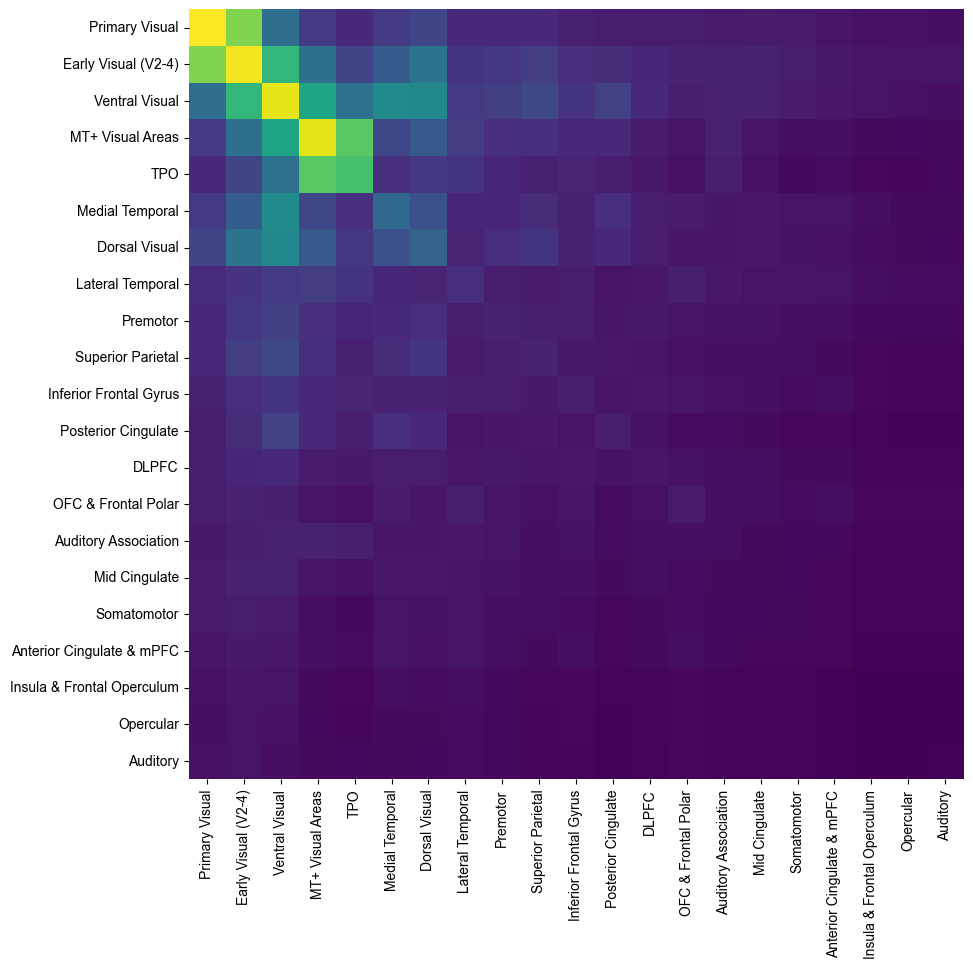

In [11]:
df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j and shift==0")
df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.groupby(["area_id_x", "area_id_y"]).score.mean().reset_index()
hcp_areas = hcp[['area', 'area_id', 'area_color']].drop_duplicates("area")

df = df.merge(hcp_areas, left_on="area_id_x", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_x", "area_color": "color_x"})
df = df.merge(hcp_areas, left_on="area_id_y", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_y", "area_color": "color_y"})

area_order = df.sort_values("area_id_x").area_x.drop_duplicates().tolist()
area_order = ['Primary Visual',
 'Early Visual (V2-4)',
 
 'Ventral Visual',
 'MT+ Visual Areas',
 'TPO',
 'Medial Temporal',
 'Dorsal Visual',
 'Lateral Temporal',    
    
 'Premotor',
 'Superior Parietal',
 'Inferior Frontal Gyrus',
 'Posterior Cingulate',
 'DLPFC',
 'OFC & Frontal Polar',
 'Auditory Association',
 'Mid Cingulate',
 'Somatomotor',
 'Anterior Cingulate & mPFC',
 'Insula & Frontal Operculum',
 'Opercular',
 'Auditory']

df_pivoted = df.pivot(index="area_x", columns="area_y", values="score")
df_pivoted = df_pivoted.loc[area_order, area_order]
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(data=df_pivoted, cmap="viridis", cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")

folder = output_folder / "heatmap_connectivity_areas"
folder.mkdir(exist_ok=True)
fig.savefig(folder / "heatmap_connectivity_areas.svg", bbox_inches="tight", transparent=True)
fig.savefig(folder / "heatmap_connectivity_areas.pdf", bbox_inches="tight", transparent=True)

### Subfigure: Alignment by areas graph

In [66]:
# Load depths
df_depth_areas = load_peak_layers(filename_model_joined, group_subjects=True)
df_depth_areas = df_depth_areas.groupby(["area_id", "area", "area_color"]).depth.mean().sort_values().reset_index()
df_depth_areas = df_depth_areas.set_index("area")

In [67]:
df = pd.read_parquet(filename_joined)

df_top_areas = df.query("subject_i == subject_j").groupby(["roi_x"]).score.mean().reset_index()
top_areas = df_top_areas.sort_values("score", ascending=False).head(40).roi_x.tolist()
df = df.query("subject_i != subject_j and shift==0")
df = df.query("roi_x in @top_areas and roi_y in @top_areas")

df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.groupby(["area_id_x", "area_id_y"]).score.mean().reset_index()
hcp_areas = hcp[['area', 'area_id', 'area_color']].drop_duplicates("area")

df = df.merge(hcp_areas, left_on="area_id_x", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_x", "area_color": "color_x"})
df = df.merge(hcp_areas, left_on="area_id_y", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_y", "area_color": "color_y"})

df

,area_id_x,area_id_y,score,area_x,color_x,area_y,color_y
0,4,4,0.034162,Lateral Temporal,#d62728,Lateral Temporal,#d62728
1,4,7,0.012919,Lateral Temporal,#d62728,TPO,#98df8a
2,4,9,0.008443,Lateral Temporal,#d62728,Mid Cingulate,#c5b0d5
3,4,10,0.012527,Lateral Temporal,#d62728,Premotor,#8c564b
4,4,13,0.009226,Lateral Temporal,#d62728,Auditory Association,#f7b6d2
...,...,...,...,...,...,...,...
116,21,16,0.007052,DLPFC,#d28fd2,Inferior Parietal,#bcbd22
117,21,17,0.006066,DLPFC,#d28fd2,Posterior Cingulate,#dbdb8d
118,21,18,0.004682,DLPFC,#d28fd2,Anterior Cingulate & mPFC,#17becf
119,21,20,0.007141,DLPFC,#d28fd2,Inferior Frontal Gyrus,#800080


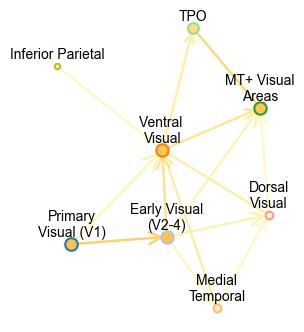

In [132]:



top = 19
df = pd.read_parquet(filename_joined)
df_top_areas = df.query("roi_x == roi_y").groupby(["roi_x"]).score.mean().reset_index()
#top_areas = df_top_areas.sort_values("score", ascending=False).head(top).roi_x.tolist()
top_areas = df_top_areas.query("score > 0.03").roi_x.tolist()
#display(df_top_areas)

df = df.query("subject_i != subject_j and shift==0")
#df = df
df = df.query("roi_x in @top_areas and roi_y in @top_areas").groupby(["roi_x", "roi_y"]).score.mean().reset_index()
#df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.groupby(["area_id_x", "area_id_y"]).score.mean().reset_index()
hcp_areas = hcp[['area', 'area_id', 'area_color']].drop_duplicates("area")

df = df.merge(hcp_areas, left_on="area_id_x", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_x", "area_color": "color_x"})
df = df.merge(hcp_areas, left_on="area_id_y", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_y", "area_color": "color_y"})

threshold_edges = 0.02

df_edges = df.query("area_x != area_y and score > @threshold_edges").copy()


#df_edges = df_edges[~((df_edges.area_x == 'Primary Visual') & (df_edges.area_y == 'Ventral Visual'))]
#df_edges = df_edges[~((df_edges.area_y == 'Primary Visual') & (df_edges.area_x == 'Ventral Visual'))]

# Get score between TPO and Ventral
#tpo_ventral = df_edges#.query("area_x == 'TPO' and area_y == 'Ventral Visual'").score.values[0]

#df_edges = df_edges[~((df_edges.area_x == 'TPO') & (df_edges.area_y == 'Ventral Visual'))]
#df_edges = df_edges[~((df_edges.area_y == 'TPO') & (df_edges.area_x == 'Ventral Visual'))]
#display(df_edges)

df_self = df.query("area_x==area_y")



#nodes = df_self.sort_values("score", ascending=False).head(20).area_x.tolist()
#df_edges = df_edges[df_edges.area_x.isin(nodes) & df_edges.area_y.isin(nodes)]

df_edges["weight"] = 30*(1 - df_edges["score"])**3

vmin, vmax = 0, 0.20

G = nx.from_pandas_edgelist(
    df_edges,
    source="area_x",
    target="area_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

pos = nx.kamada_kawai_layout(G, dim=2, weight="weight", center=(0, 0))
#pos['Dorsal Visual'], pos['Posterior Cingulate'] = pos['Posterior Cingulate'], pos['Dorsal Visual']
# pos['Primary Visual'] = (0, pos['Primary Visual'][1])
# pos['Early Visual (V2-4)'] = (0, pos['Early Visual (V2-4)'][1])
# pos['Ventral Visual'] = (0, pos['Ventral Visual'][1])
# pos['MT+ Visual Areas'] = (0, pos['MT+ Visual Areas'][1])
# pos['TPO'] = (0, pos['TPO'][1])

for k in pos:
    pos[k] = -pos[k]

#pos['Medial Temporal'] += (-0.25, -0.1)
pos['MT+ Visual Areas'] += (0.1, 0)
pos['TPO'] += (-0.1, -0.1)

node_score = df.query("area_x == area_y").set_index("area_x")[["score"]].to_dict(orient="index")

# Draw the graph
fig, ax = plt.subplots(figsize=(3, 4))
ax.axis("off")
cmap = plt.get_cmap("YlOrBr")
norm = plt.Normalize(vmin=vmin, vmax=vmax)

node_positions = {node: pos[node] for node in G.nodes()}


for node, (x, y) in node_positions.items():
    score = node_score[node]["score"]
    norm_score = norm(score)
    color = cmap(norm_score)
    s = 5 + 200 * norm_score
    area_color = df.query("area_x == @node").color_x.values[0]

    ax.scatter(
        x,
        y,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
    )
    if 'Early' in node:
        node = 'Early Visual\n(V2-4)'
    if 'MT+' in node:
        node = 'MT+ Visual\nAreas'
    if 'Ventral' in node:
        node = 'Ventral \nVisual'
    if 'Posterior' in node:
        node = 'Posterior\nCingulate'
    if 'Medial' in node:
        node = 'Medial\nTemporal'
    if 'Dorsal' in node:
        node = 'Dorsal\nVisual'
    if 'Primary' in node:
        node = 'Primary\nVisual (V1)'
    ax.text(x, y + 0.05, node, fontsize=10, ha="center", zorder=1000)


edge_positions = [
    (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
]

edge_positions.append(('TPO', 'Ventral Visual', pos['TPO'], pos['Ventral Visual'], tpo_ventral))

for name_x, name_y, start, end, score in edge_positions:

    # if 'Primary' in name_x and 'Ventral' in name_y: continue
    #if 'Ventral' in name_x and 'TPO' in name_y: continue
    xs, ys = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1.5 + 1 * normalize_edge_weight
    color = cmap(normalize_edge_weight)

    depth_x = float(df_depth_areas.loc[name_x].depth)
    depth_y = float(df_depth_areas.loc[name_y].depth)

    diff = abs(depth_x - depth_y)
    if diff < 0.02:
        direction = "-"
    else:
        direction = "->" if depth_x < depth_y else "<-"
    #print(name_x, name_y, diff)
    
    plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=15+diff*30)

folder = output_folder / "connectivity_graph_areas"
folder.mkdir(exist_ok=True)

fig.savefig(folder / f"connectivity_graph_areas_top_{top}_agg.svg", dpi=300, bbox_inches="tight", transparent=True)




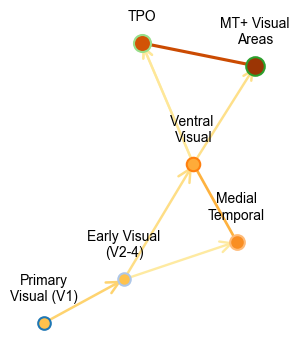

In [226]:



top = 19
df = pd.read_parquet(filename_joined)
df_top_areas = df.query("roi_x == roi_y").groupby(["roi_x"]).score.mean().reset_index()
top_areas = df_top_areas.sort_values("score", ascending=False).head(top).roi_x.tolist()


df = df.query("subject_i != subject_j and shift==0")
#df = df
df = df.query("roi_x in @top_areas and roi_y in @top_areas").groupby(["roi_x", "roi_y"]).score.mean().reset_index()
#df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[['roi', 'area_id']], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.groupby(["area_id_x", "area_id_y"]).score.mean().reset_index()
hcp_areas = hcp[['area', 'area_id', 'area_color']].drop_duplicates("area")

df = df.merge(hcp_areas, left_on="area_id_x", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_x", "area_color": "color_x"})
df = df.merge(hcp_areas, left_on="area_id_y", right_on="area_id").drop(columns="area_id").rename(columns={"area": "area_y", "area_color": "color_y"})

threshold_edges = 0.03

df_edges = df.query("area_x != area_y and score > @threshold_edges").copy()


#df_edges = df_edges[~((df_edges.area_x == 'Primary Visual') & (df_edges.area_y == 'Ventral Visual'))]
#df_edges = df_edges[~((df_edges.area_y == 'Primary Visual') & (df_edges.area_x == 'Ventral Visual'))]

# Get score between TPO and Ventral
#tpo_ventral = df_edges.query("area_x == 'TPO' and area_y == 'Ventral Visual'").score.values[0]

#df_edges = df_edges[~((df_edges.area_x == 'TPO') & (df_edges.area_y == 'Ventral Visual'))]
#df_edges = df_edges[~((df_edges.area_y == 'TPO') & (df_edges.area_x == 'Ventral Visual'))]
#display(df_edges)

df_self = df.query("area_x==area_y")



#nodes = df_self.sort_values("score", ascending=False).head(20).area_x.tolist()
#df_edges = df_edges[df_edges.area_x.isin(nodes) & df_edges.area_y.isin(nodes)]

df_edges["weight"] = 30*(1 - df_edges["score"])**3

vmin, vmax = 0, 0.20

G = nx.from_pandas_edgelist(
    df_edges,
    source="area_x",
    target="area_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

pos = nx.kamada_kawai_layout(G, dim=2, weight="weight", center=(0, 0))
#pos['Dorsal Visual'], pos['Posterior Cingulate'] = pos['Posterior Cingulate'], pos['Dorsal Visual']
# pos['Primary Visual'] = (0, pos['Primary Visual'][1])
# pos['Early Visual (V2-4)'] = (0, pos['Early Visual (V2-4)'][1])
# pos['Ventral Visual'] = (0, pos['Ventral Visual'][1])
# pos['MT+ Visual Areas'] = (0, pos['MT+ Visual Areas'][1])
# pos['TPO'] = (0, pos['TPO'][1])

for k in pos:
    pos[k] = -pos[k]

pos['Medial Temporal'] += (-0.25, 0.1)
pos['MT+ Visual Areas'] += (-0.4, -0.3)
pos['TPO'] += (-0.6, -0.5)
pos['Medial Temporal'] += (0.2, 0.22)
pos['Ventral Visual'] += (-0.2, -0.1)
pos['Primary Visual'] += (0.2, 0.1)

node_score = df.query("area_x == area_y").set_index("area_x")[["score"]].to_dict(orient="index")

# Draw the graph
fig, ax = plt.subplots(figsize=(3, 4))
ax.axis("off")
cmap = plt.get_cmap("YlOrBr")
norm = plt.Normalize(vmin=vmin, vmax=vmax)

node_positions = {node: pos[node] for node in G.nodes()}


for node, (x, y) in node_positions.items():
    score = node_score[node]["score"]
    norm_score = norm(score)
    color = cmap(norm_score)
    s = 5 + 200 * norm_score
    area_color = df.query("area_x == @node").color_x.values[0]

    ax.scatter(
        x,
        y,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
    )
    if 'Early' in node:
        node = 'Early Visual\n(V2-4)'
    if 'MT+' in node:
        node = 'MT+ Visual\nAreas'
    if 'Ventral' in node:
        node = 'Ventral \nVisual'
    if 'Posterior' in node:
        node = 'Posterior\nCingulate'
    if 'Medial' in node:
        node = 'Medial\nTemporal'
    if 'Dorsal' in node:
        node = 'Dorsal\nVisual'
    if 'Primary' in node:
        node = 'Primary\nVisual (V1)'
    ax.text(x, y + 0.05, node, fontsize=10, ha="center", zorder=1000)


edge_positions = [
    (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
]

edge_positions.append(('TPO', 'Ventral Visual', pos['TPO'], pos['Ventral Visual'], tpo_ventral))

for name_x, name_y, start, end, score in edge_positions:

    # if 'Primary' in name_x and 'Ventral' in name_y: continue
    #if 'Ventral' in name_x and 'TPO' in name_y: continue
    xs, ys = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1.5 + 1 * normalize_edge_weight
    color = cmap(normalize_edge_weight)

    depth_x = float(df_depth_areas.loc[name_x].depth)
    depth_y = float(df_depth_areas.loc[name_y].depth)

    diff = abs(depth_x - depth_y)
    if diff < 0.05 or (name_y == "Medial Temporal" and name_x == "Ventral Visual"):
        direction = "-"
    else:
        direction = "->" if depth_x < depth_y else "<-"
    #print(name_x, name_y, diff)
    
    plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=15+diff*30)

folder = output_folder / "connectivity_graph_areas"
folder.mkdir(exist_ok=True)

fig.savefig(folder / f"connectivity_graph_areas_top_{top}.svg", dpi=300, bbox_inches="tight", transparent=True)




In [18]:
df_edges

,area_id_x,area_id_y,score,area_x,color_x,area_y,color_y,weight
1,0,1,0.062659,Primary Visual,#1f77b4,Early Visual (V2-4),#aec7e8,0.937341
8,1,0,0.062610,Early Visual (V2-4),#aec7e8,Primary Visual,#1f77b4,0.937390
10,1,2,0.054631,Early Visual (V2-4),#aec7e8,Ventral Visual,#ff7f0e,0.945369
11,1,3,0.045055,Early Visual (V2-4),#aec7e8,Dorsal Visual,#ffbb78,0.954945
13,1,5,0.041007,Early Visual (V2-4),#aec7e8,Medial Temporal,#98df8a,0.958993
17,2,1,0.054643,Ventral Visual,#ff7f0e,Early Visual (V2-4),#aec7e8,0.945357
19,2,3,0.067543,Ventral Visual,#ff7f0e,Dorsal Visual,#ffbb78,0.932457
20,2,4,0.055347,Ventral Visual,#ff7f0e,MT+ Visual Areas,#2ca02c,0.944653
21,2,5,0.085562,Ventral Visual,#ff7f0e,Medial Temporal,#98df8a,0.914438
23,2,17,0.052877,Ventral Visual,#ff7f0e,Posterior Cingulate,#dbdb8d,0.947123


In [19]:
df[df['area_x'] == 'Medial Temporal'].sort_values('score', ascending=False)

,area_id_x,area_id_y,score,area_x,color_x,area_y,color_y
45,5,5,0.106705,Medial Temporal,#98df8a,Medial Temporal,#98df8a
42,5,2,0.085574,Medial Temporal,#98df8a,Ventral Visual,#ff7f0e
47,5,17,0.070370,Medial Temporal,#98df8a,Posterior Cingulate,#dbdb8d
43,5,3,0.064587,Medial Temporal,#98df8a,Dorsal Visual,#ffbb78
41,5,1,0.041063,Medial Temporal,#98df8a,Early Visual (V2-4),#aec7e8
44,5,4,0.035141,Medial Temporal,#98df8a,MT+ Visual Areas,#2ca02c
46,5,7,0.025254,Medial Temporal,#98df8a,TPO,#ff9896
40,5,0,0.020205,Medial Temporal,#98df8a,Primary Visual,#1f77b4


df

### Subfig connectome

In [33]:

labels = get_hcp_labels()

subjects_dir = mne.datasets.sample.data_path() / "subjects"
label_coors = []
for label in labels:
    name = label.name
    if '?' in name: continue
    
    mni_coords = mne.vertex_to_mni(
        vertices=label.vertices,
        hemis=0 if label.hemi == 'lh' else 1,
        subject='fsaverage',
        subjects_dir=subjects_dir
    )
    
    label_coors.append({
        "mne_name": name,
        "coordinates": np.mean(mni_coords, axis=0),
    })

df_coors = pd.DataFrame(label_coors)
hcp = pd.read_csv(filename_hcp)
df_coors = df_coors.merge(hcp[['mne_name', 'roi', 'area', 'area_id', 'name', 'roi_order', 'area_color']], left_on="mne_name", right_on="mne_name")



df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).score.mean().reset_index()
df = df.query("roi_x in @top_areas and roi_y in @top_areas")
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})
df = df.pivot(index="name_x", columns="name_y", values="score")
order = df.index.tolist()
df = df.loc[order, order]
matrix = df.values


values = df_coors.query('roi <= 180').set_index("name").loc[order].coordinates.tolist()
coors_data = np.array([v.tolist() for v in values])
colors = df_coors.query('roi <= 180').set_index("name").loc[order].area_color.tolist()

# Make matrix symmetric
for i in range(matrix.shape[0]):
    for j in range(i, matrix.shape[1]):
        matrix[j, i] = matrix[i, j]


# Matrix is a n x n
# Coors data # n x 3
edge_threshold = 0.02
self_connections = df_self.set_index("name_x").loc[order].score.values
node_size = self_connections*80 + 0.5
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
projectors = plot_connectome(matrix, coors_data, edge_threshold=edge_threshold, node_size=node_size, node_color=colors, edge_vmax=0.20, edge_vmin=0, display_mode="ortho", axes=ax, edge_cmap='Oranges', node_kwargs={"edgecolors": "black", "linewidths": 0.3})

folder = output_folder / "connectome_graph"
folder.mkdir(exist_ok=True)
#fig.savefig(folder / "connectome_graph_cka_cross_subject2.svg", dpi=300, bbox_inches="tight", transparent=True)
#fig.savefig(folder / "connectome_graph_cka_cross_subject2.pdf", dpi=300, bbox_inches="tight", transparent=True)

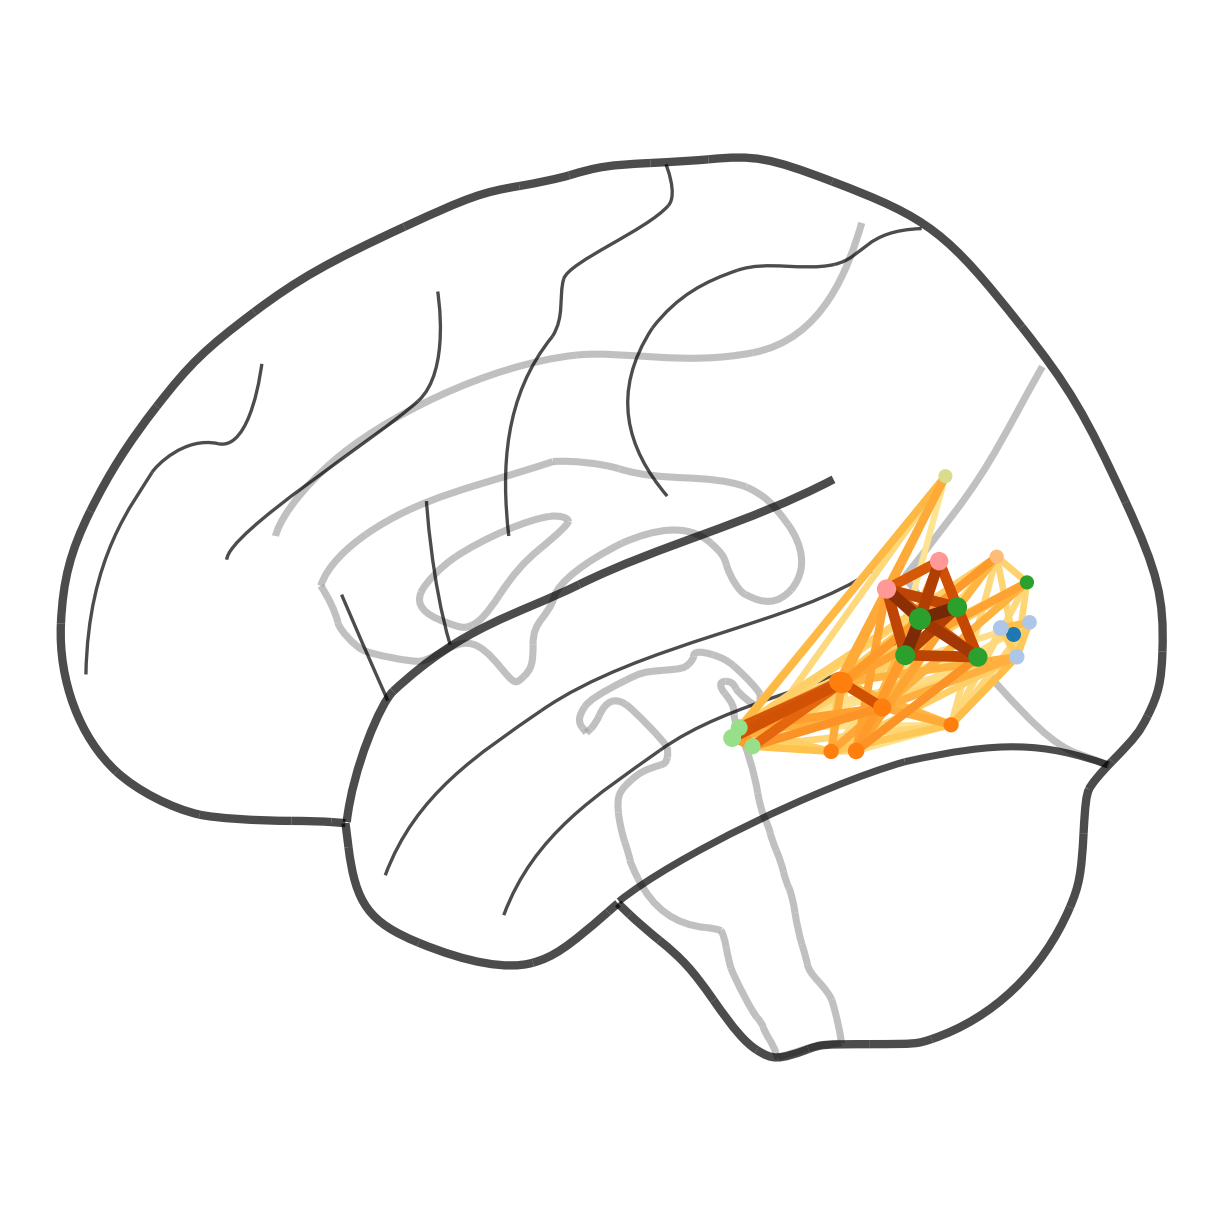

In [36]:

edge_threshold = 0.05
self_connections = df_self.set_index("name_x").loc[order].score.values
node_size = self_connections*80 + 0.5
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
projectors = plot_connectome(matrix, coors_data, edge_threshold=edge_threshold, node_size=node_size, node_color=colors, edge_vmax=0.20, edge_vmin=0, display_mode="l", axes=ax, edge_cmap='YlOrBr')#, node_kwargs={"edgecolors": "black", "linewidths": 0.3})


fig.savefig(folder / "connectome_graph_cka_cross_subject_l2.svg", dpi=300, bbox_inches="tight", transparent=True)
fig.savefig(folder / "connectome_graph_cka_cross_subject_l2.pdf", dpi=300, bbox_inches="tight", transparent=True)



In [25]:
self_connections

array([0.00614657, 0.00509215, 0.00598543, 0.00305777, 0.00675911,
       0.01122846, 0.00566753, 0.00544792, 0.00627748, 0.00566507,
       0.00421586, 0.00220035, 0.00492178, 0.00665972, 0.00414841,
       0.00267457, 0.0036461 , 0.00173451, 0.0032705 , 0.00465445,
       0.00286538, 0.00423226, 0.00473604, 0.00609979, 0.00423464,
       0.00911782, 0.00509839, 0.00226289, 0.01001279, 0.00304143,
       0.00184085, 0.00422748, 0.01180413, 0.00805577, 0.00592724,
       0.00449621, 0.0070264 , 0.00477382, 0.00458764, 0.00845936,
       0.00855966, 0.01381123, 0.00933276, 0.00578961, 0.00483865,
       0.00734237, 0.00382829, 0.00586801, 0.01537193, 0.00497495,
       0.00480482, 0.00445079, 0.00492582, 0.00163871, 0.00454443,
       0.00578093, 0.00172448, 0.00861477, 0.00409484, 0.06344439,
       0.00744466, 0.02471166, 0.10265955, 0.00185398, 0.00329449,
       0.00232595, 0.00179197, 0.00292587, 0.17120621, 0.0074748 ,
       0.01579197, 0.01712856, 0.00866272, 0.01447065, 0.04506

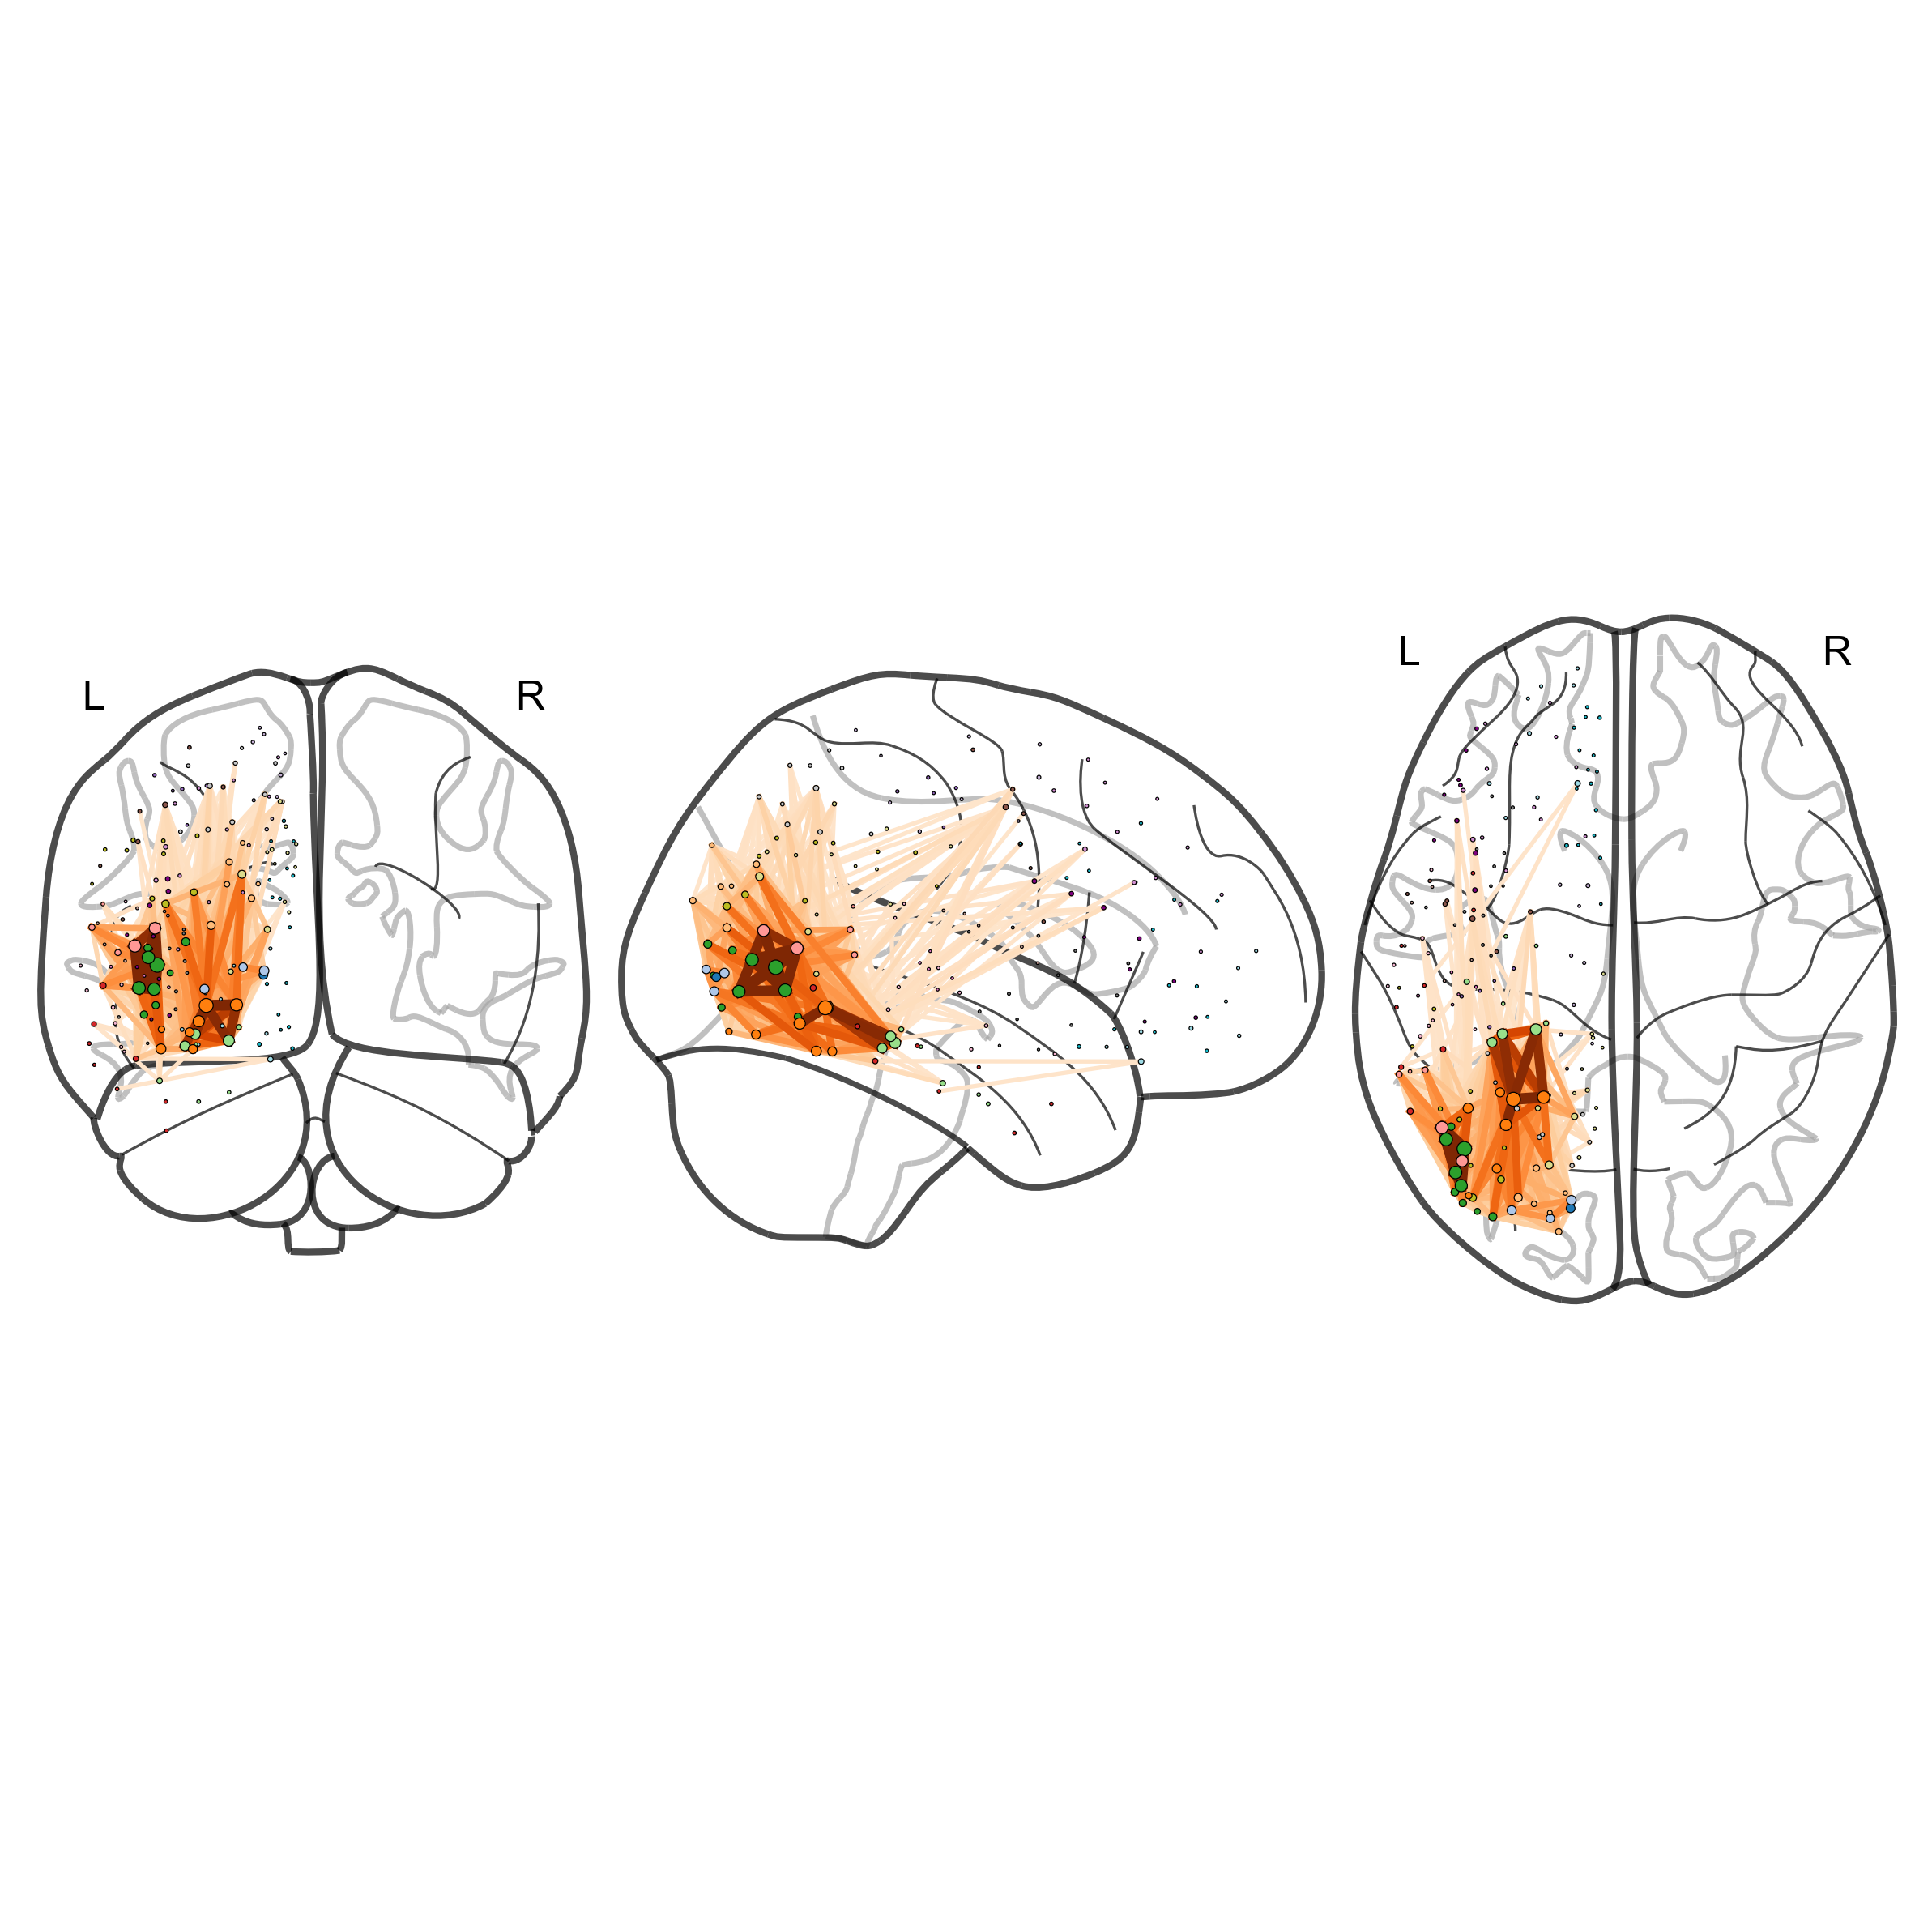

In [129]:
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


In [30]:
%matplotlib qt
# 3D matplotlib
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_parquet(filename_joined)
df = df.query("subject_i != subject_j and shift==0")
df = df.groupby(["roi_x", "roi_y"]).score.mean().reset_index()
hcp = pd.read_csv(filename_hcp)
df = df.merge(hcp[["roi", "name"]], left_on="roi_x", right_on="roi").drop(columns="roi").rename(columns={"name": "name_x"})
df = df.merge(hcp[["roi", "name"]], left_on="roi_y", right_on="roi").drop(columns="roi").rename(columns={"name": "name_y"})


threshold_edges = 0.051
top_nodes = 20

df_edges = df.query("name_x != name_y and score > @threshold_edges").copy()

df_self = df.query("name_x==name_y")
nodes = df_self.sort_values("score", ascending=False).head(top_nodes).name_x.tolist()

df_edges = df_edges[df_edges.name_x.isin(nodes) & df_edges.name_y.isin(nodes)]

#counts = df_edges.roi_x.value_counts()
#counts[counts > 1]
#df_edges = df_edges[df_edges.roi_x.isin(counts[counts > 1].index) & df_edges.roi_y.isin(counts[counts > 1].index)]

df_nodes = df.query("name_x == name_y")
df_nodes = df_nodes[df_nodes.roi_x.isin(df_edges.roi_x)]
df_edges["weight"] = 100* (1 - df_edges["score"])
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

vmin, vmax = 0, 0.18
cmap = plt.get_cmap("YlOrBr")

G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)
pos = nx.kamada_kawai_layout(G, dim=3, weight="weight", center=(0, 0, 0))
#if 'VVC' in pos:
#    pos["VVC"] += (-0.1, 0.)
#pos["VMV2"] += (0.1, 0.1)
# #pos = nx.spring_layout(G, weight="weight", center=(0, 0), scale=2)
# if top_nodes == 20:
#     pos["MST"] += (0.1, -0.1)
#     pos["VMV3"] += (0, -0.1)
#     pos["V8"] += (0, 0.1)
#     pos["TPOJ2"], pos["V4t"] = pos["V4t"], pos["TPOJ2"]
#     pos["VMV1"], pos["PHA3"] = pos["PHA3"], pos["VMV1"]


node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")

# Draw the graph
#fig, ax = plt.subplots(figsize=(6, 8))
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection='3d')
ax.axis("off")

#cmap = plt.get_cmap("magma")
norm = plt.Normalize(vmin=vmin, vmax=vmax)



node_positions = {node: pos[node] for node in G.nodes()}
for node, (x, y, z) in node_positions.items():
    if node not in node_score:
        continue
    score = node_score[node]["score"]
    norm_score = norm(score)


    color = cmap(norm_score)
    s = 5 + 200 * norm_score
    area_color = colors[areas[node]]

    marker = "o"
    ax.scatter(
        x,
        y,
        z,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
        marker=marker,
    )

    # color = f"C{communities[node]}"#communities_colors[communities[node]]
    
    ax.text(x, y + 0.05, z, node, fontsize=10, ha="center", zorder=1000)

edge_positions = [
    (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
]


depths = []
for name_x, name_y, start, end, score in edge_positions:
    if name_x not in node_score or name_y not in node_score:
        continue
    xs, ys, zs = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1.5 + 1 * normalize_edge_weight
    color = cmap(normalize_edge_weight)


    # depth_x = float(df_peaks_name.loc[name_x].depth)
    # depth_y = float(df_peaks_name.loc[name_y].depth)

    # diff = abs(depth_x - depth_y)
    # #color = cmap(diff*2)

    # if diff < 0.02:
    #     direction = "-"
    # elif depth_x < depth_y:
    #     direction = "->"
    # elif depth_x > depth_y:
    #     direction = "<-"
    # else:
    #     direction = "-"



    # ax.plot(xs, ys, zs, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100)

    ax.quiver(
        start[0], start[1], start[2], end[0] - start[0], end[1] - start[1], end[2] - start[2], # <-- directions of vector
        #v[0] - mean_x, v[1] - mean_y, v[2] - mean_z, # <-- directions of vector
        color = color, alpha = 1, lw =lw, zorder=normalize_edge_weight * 100,
        arrow_length_ratio=0.1
    )

    #plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=15+diff*30)
